In [1]:
import torch
import einops
import numpy as np
from torch import nn
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [2]:
class SpatialGatingUnit(nn.Module):
    def __init__(self, seq_len, d_ffn):
        super().__init__()
        self.norm = nn.LayerNorm(d_ffn)
        self.spatial_proj = nn.Conv1d(seq_len, seq_len, kernel_size=1) #pointwise convolution, used to learn a set of weights for each position
        nn.init.constant_(self.spatial_proj.bias, 1.0) #bias initialization
 
    def forward(self, x):
        u, v = x.chunk(2, dim=-1) # we split the input along the last dimension
        v = self.norm(v) # we apply layer normalization to the second part
        v = self.spatial_proj(v) # we project the second part to the same dimension as the first part by using a 1D convolution
        return u * v

In [3]:
class gMLPBlock(nn.Module): #Gated MLP block
    def __init__(self, seq_len, d_model, d_ffn):
        super().__init__()
        self.block = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 2 * d_ffn), # channel proj
            nn.GELU(), #Gaussian Error Linear Units
            SpatialGatingUnit(seq_len, d_ffn), # contains spatial proj, in which we project the output of SGU back to d_model dimension
            nn.Linear(d_ffn, d_model) # channel proj
        )

    def forward(self, x):
        return x + self.block(x) # residual connection, helps to avoid vanishing gradient problem
                                 # we add the output of the block to the input of the block

In [4]:
class gMLP(nn.Module):
    def __init__(self, seq_len=256, d_model=256, d_ffn=512, n_layers=6):
        super().__init__()
        self.blocks = nn.Sequential(
            *[gMLPBlock(seq_len, d_model, d_ffn) for _ in range(n_layers)]
        )

    def forward(self, x):
        return self.blocks(x)

In [5]:
class gMLPVisionModel(nn.Module):
    def __init__(self, in_channels=3, image_size=64, patch_size=8, d_model=256, d_ffn=512, n_layers=6, n_classes=10, dropout=0.1):
        # d_model = dimension of the output of gMLP block 
        # d_ffn = dimension of the feedforward network
        super().__init__()
        assert image_size % patch_size == 0, "image size must be divisible by patch size!!"
        n_patches = (image_size // patch_size) ** 2
        self.dropout = nn.Dropout(dropout)
        self.patch_embedding = nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.gmlp = gMLP(n_patches, d_model, d_ffn, n_layers)
        self.bn = nn.BatchNorm1d(d_model)
        self.fc_out = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = x.permute(0, 2, 3, 1)  # rearrange dimensions to (batch_size, height, width, channels)
        x = x.contiguous().view(x.size(0), -1, x.size(-1))  # flatten height and width dimensions
        #x = einops.rearrange(x, "batch_size channels height width -> batch_size (height*weight) channels")
        
        x = self.gmlp(x)
        x = x.mean(1)
        out = self.fc_out(x)
        return out

In [6]:
# # hyperparameters for vision and language models
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_epochs = 10
# seq_len = 128
# img_size = 32
# batch_size = 64
# n_classes = 10
# lr = 3e-4
# T = transforms.Compose(
#     [
#      transforms.Resize((img_size, img_size)),
#      transforms.ToTensor()
#     ]
# )
# print(device)

In [7]:
# vision model

In [8]:
# train_data_vm = datasets.CIFAR10("data/", train=True, download=True, transform=T)
# val_data_vm = datasets.CIFAR10("data/", train=False, download=True, transform=T)
# train_loader_vm = DataLoader(train_data_vm, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
# val_loader_vm = DataLoader(val_data_vm, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
# x, y = next(iter(train_loader_vm))
# print(len(train_data_vm), x.shape, y.shape)

In [9]:
# gmlp_vm = gMLPVisionModel(n_classes=n_classes).to(device)
# inp = torch.randn(1, 3, img_size, img_size).to(device)
# out = gmlp_vm(inp)
# print(out.shape)
# del inp, out

In [10]:
# optimizer_vm = torch.optim.Adam(gmlp_vm.parameters(), lr=lr)
# loss_fn_vm = nn.CrossEntropyLoss()
# def get_accuracy(preds, y):
#     preds = preds.argmax(dim=1, keepdim=True)
#     correct = preds.squeeze(1).eq(y)
#     acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
#     return acc

In [11]:
def loop_vm(net, loader, is_train):
    net.train(is_train)
    losses = []
    accs = []
    pbar = tqdm(loader, total=len(loader))
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)
        with torch.set_grad_enabled(is_train):
            preds = net(x)
            loss = loss_fn_vm(preds, y)
            acc = get_accuracy(preds, y)
            losses.append(loss.item())
            accs.append(acc.item())
        if is_train:
            optimizer_vm.zero_grad()
            loss.backward()
            optimizer_vm.step()
        pbar.set_description(f'epoch={epoch}, train={int(is_train)}, loss={np.mean(losses):.4f}, acc={np.mean(accs):.4f}')

In [12]:
# for epoch in range(n_epochs):
#     loop_vm(gmlp_vm, train_loader_vm, True)
#     loop_vm(gmlp_vm, val_loader_vm, False)

In [13]:
@torch.no_grad()
def recognize_img(net, img):
    net.eval()
    img = Image.open(img).convert("RGB")
    img = T(img).to(device)
    pred = net(img.unsqueeze(0))
    pred = pred.argmax(dim=1)
    return train_data_vm.classes[pred.item()]

In [14]:
# out = recognize_img(gmlp_vm, 'dog.jpg')
# print(out)

** Try with tiny image net 

In [15]:
# # hyperparameters for vision and language models
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_epochs = 10
# seq_len = 128
# img_size = 64
# batch_size = 64
# n_classes = 200
# lr = 3e-4
# T = transforms.Compose(
#     [
#      transforms.Resize((img_size, img_size)),
#      transforms.ToTensor()
#     ]
# )

In [16]:
# # # Tiny Imagenet dataset

# # Load the Tiny ImageNet dataset
# train_data_tiny_imagenet = datasets.ImageFolder('tiny-imagenet-200/train', transform=T)
# val_data_tiny_imagenet = datasets.ImageFolder('tiny-imagenet-200/val', transform=T)

# # Create data loaders for Tiny ImageNet
# train_loader_tiny_imagenet = DataLoader(train_data_tiny_imagenet, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
# val_loader_tiny_imagenet = DataLoader(val_data_tiny_imagenet, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# # Print the shapes of the datasets
# x_vm, y_vm = next(iter(val_loader_tiny_imagenet))
# x_tiny_imagenet, y_tiny_imagenet = next(iter(train_loader_tiny_imagenet))
# print(len(val_data_tiny_imagenet), x_vm.shape, y_vm.shape)
# print(len(train_data_tiny_imagenet), x_tiny_imagenet.shape, y_tiny_imagenet.shape)

In [17]:
# gmlp_vm = gMLPVisionModel(n_classes=n_classes).to(device)
# inp = torch.randn(1, 3, img_size, img_size).to(device)
# out = gmlp_vm(inp)
# print(out.shape)
# del inp, out

In [18]:
# optimizer_vm = torch.optim.Adam(gmlp_vm.parameters(), lr=lr)
# loss_fn_vm = nn.CrossEntropyLoss()
# def get_accuracy(preds, y):
#     preds = preds.argmax(dim=1, keepdim=True)
#     correct = preds.squeeze(1).eq(y)
#     acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
#     return acc

In [19]:
#for epoch in range(n_epochs):
    #loop_vm(gmlp_vm, train_loader_tiny_imagenet, True)
    #loop_vm(gmlp_vm, val_loader_tiny_imagenet, False)

In [20]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Evaluate the model on the test dataset
def evaluate_model(net, loader):
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    return accuracy, precision, recall, conf_matrix

# Evaluate the model on the test dataset
#test_accuracy = evaluate_model(gmlp_vm, test_loader_tiny_imagenet)
#print(f"Test Accuracy: {test_accuracy:.2f}%")


** Try with fashion MNIST

In [21]:
# # hyperparameters for vision and language models
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# n_epochs = 1
# seq_len = 128
# img_size = 28
# batch_size = 128
# n_classes = 10
# lr = 3e-4
# T = transforms.Compose(
#     [
#      transforms.Resize((img_size, img_size)),
#      transforms.ToTensor()
#     ]
# )

In [22]:
# from torch.utils.data import random_split

# # Load the Fashion-MNIST dataset
# full_train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=T)
# test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=T)

# # Split the full training dataset into a training dataset and a validation dataset
# num_train = int(len(full_train_data) * 0.8)
# num_val = len(full_train_data) - num_train
# train_data, val_data = random_split(full_train_data, [num_train, num_val])

# # Create data loaders
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Print the shapes of the datasets
# x_train, y_train = next(iter(train_loader))
# x_val, y_val = next(iter(val_loader))
# x_test, y_test = next(iter(test_loader))
# print(len(train_data), x_train.shape, y_train.shape)
# print(len(val_data), x_val.shape, y_val.shape)
# print(len(test_data), x_test.shape, y_test.shape)

In [23]:
# gmlp_vm = gMLPVisionModel(in_channels=1, n_classes=n_classes, image_size=28, patch_size=2, d_model=256, d_ffn=512, n_layers=6, dropout=0.1).to(device)
# inp = torch.randn(1, 1, img_size, img_size).to(device)
# out = gmlp_vm(inp)
# print(out.shape)
# del inp, out

In [24]:
# optimizer_vm = torch.optim.Adam(gmlp_vm.parameters(), lr=lr)
# loss_fn_vm = nn.CrossEntropyLoss()
# def get_accuracy(preds, y):
#     preds = preds.argmax(dim=1, keepdim=True)
#     correct = preds.squeeze(1).eq(y)
#     acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
#     return acc

In [25]:
# for epoch in range(n_epochs):
#     loop_vm(gmlp_vm, train_loader, True)
#     loop_vm(gmlp_vm, val_loader, False)

In [26]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Evaluate the model and get the confusion matrix
# test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp_vm, test_loader)

# # Print the metrics
# print(f"Test Accuracy: {test_accuracy:.2f}%")
# print(f"Test Precision: {test_precision * 100:.2f}%")
# print(f"Test Recall: {test_recall * 100:.2f}%")

# class_names = test_data.classes

# # Plot the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

** Try EuroSAT dataset

In [27]:
# hyperparameters for vision and language models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_epochs = 10
seq_len = 128
img_size = 28
batch_size = 64
n_classes = 10
lr = 3e-4
T = transforms.Compose(
    [
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor()
    ]
)

In [28]:
from sklearn.model_selection import train_test_split
from PIL import Image

# Load the EuroSAT dataset
full_data = datasets.DatasetFolder(root='./EuroSAT_RGB', loader=Image.open, transform=T, extensions = 'jpg')

# Get the targets
targets = full_data.targets

# Split the full dataset into a training dataset and a temporary dataset
train_data, temp_data, train_targets, temp_targets = train_test_split(full_data, targets, test_size=0.2, stratify=targets)

# Split the temporary dataset into validation and test datasets
val_data, test_data, val_targets, test_targets = train_test_split(temp_data, temp_targets, test_size=0.5, stratify=temp_targets)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=3, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)


# Print the shapes of the datasets
x_train, y_train = next(iter(train_loader))
x_val, y_val = next(iter(val_loader))
x_test, y_test = next(iter(test_loader))
print(len(train_data), x_train.shape, y_train.shape)
print(len(val_data), x_val.shape, y_val.shape)
print(len(test_data), x_test.shape, y_test.shape)

21600 torch.Size([64, 3, 28, 28]) torch.Size([64])
2700 torch.Size([64, 3, 28, 28]) torch.Size([64])
2700 torch.Size([64, 3, 28, 28]) torch.Size([64])


In [29]:
gmlp_vm = gMLPVisionModel(in_channels=3, n_classes=n_classes, image_size=28, patch_size=2, d_model=256, d_ffn=512, n_layers=6, dropout=0.1).to(device)
inp = torch.randn(1, 3, img_size, img_size).to(device)
out = gmlp_vm(inp)
print(out.shape)
del inp, out

torch.Size([1, 10])


In [30]:
optimizer_vm = torch.optim.Adam(gmlp_vm.parameters(), lr=lr)
loss_fn_vm = nn.CrossEntropyLoss()
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

In [31]:
for epoch in range(n_epochs):
    loop_vm(gmlp_vm, train_loader, True)
    loop_vm(gmlp_vm, val_loader, False)

epoch=9, train=0, loss=0.3066, acc=0.9025: 100%|██████████| 42/42 [00:12<00:00,  3.31it/s]


Evaluating: 100%|██████████| 42/42 [00:11<00:00,  3.53it/s]


Test Accuracy: 89.84%
Test Precision: 89.84%
Test Recall: 89.84%


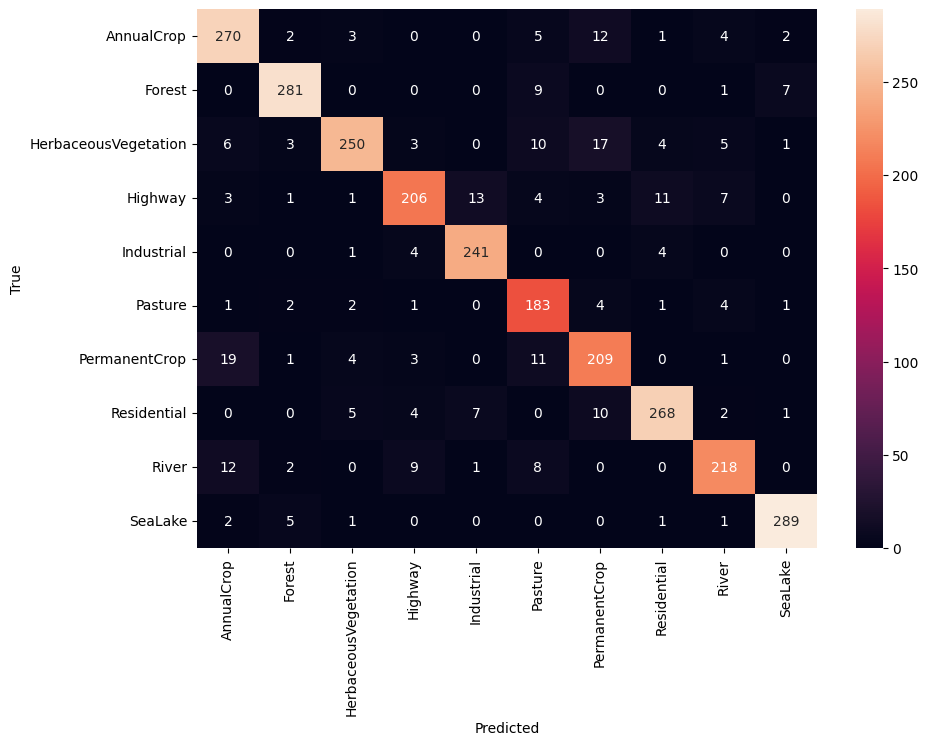

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model and get the confusion matrix
test_accuracy, test_precision, test_recall, conf_matrix = evaluate_model(gmlp_vm, test_loader)

# Print the metrics
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Precision: {test_precision * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")

class_names = full_data.classes

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()